In [1]:
using Pkg
Pkg.activate(".")
using Queryverse, Glob, JSON, CSV, DataFrames, DisplayAs
#using SimilaritySearch, SimSearchManifoldLearning, JLD2, JSON, Plots, LinearAlgebra, HypertextLiteral

  Activating project at `~/Research/SurrogateDistanceModels/notebooks`


In [2]:
function read_dataframe(pat)
    J = JSON.parse.(read.(glob("../data/*$pat*.json"), String))
    for j in J
        j["surrogate"] = get(j, "surrogate", "plain")
    end
    
    T = DataFrame.(J)
    reduce((a,b) -> vcat(a, b; cols=:union), T) |> @mutate(mem=ceil(Int, _.mem/2^20)) |> DataFrame
end

read_dataframe (generic function with 1 method)

In [3]:
function nick(r)
    
    m = string(r.method, " ", r.surrogate)
    if r.surrogate == "BHS"
        rnd = 50
        np = ceil(Int, get(r.npairs) / rnd) * rnd
        string(m, " np=", np)
    elseif r.surrogate == "MaxHash"
        string(m, " ss=", get(r.samplesize))
    else
        m
    end
end

nick (generic function with 1 method)

In [4]:

function plot_performance(D, title)
    #D |> @mutate(nick=nick(_.method,  _.surrogate), size=(_.mem)^2) |> @vlplot(
    D |> @mutate(nick=nick(_), size=(_.mem)^2) |> @vlplot(
        mark={
            :point,
            point={filled=false, fill=:white}
        },
        x={
            field=:recall
        },
        y={
            field=:searchtime,
            scale={type="log", base="10"}
        },
        color={
            :nick,
            title="color",        
        },
        shape={
            field=:surrogate
        },
        size="size:q",
        width=600,
        height=400,
        title=title
    ) |> DisplayAs.PNG
end

plot_performance (generic function with 1 method)

In [5]:

function plot_encode(D, title)
    #D |> @mutate(nick=nick(_.method,  _.surrogate), size=(_.mem)^2) |> @vlplot(
    D |> @mutate(nick=nick(_), size=(_.mem)^2) |> @vlplot(
        mark={
            :point,
            point={filled=false, fill=:white}
        },
        x={
            field=:recall
        },
        y={
            field=:enctime
        },
        color={
            :nick,
            title="color",        
        },
        shape={
            field=:surrogate
        },
        size="size:q",
        width=600,
        height=400,
        title=title
    ) |> DisplayAs.PNG
end

plot_encode (generic function with 1 method)

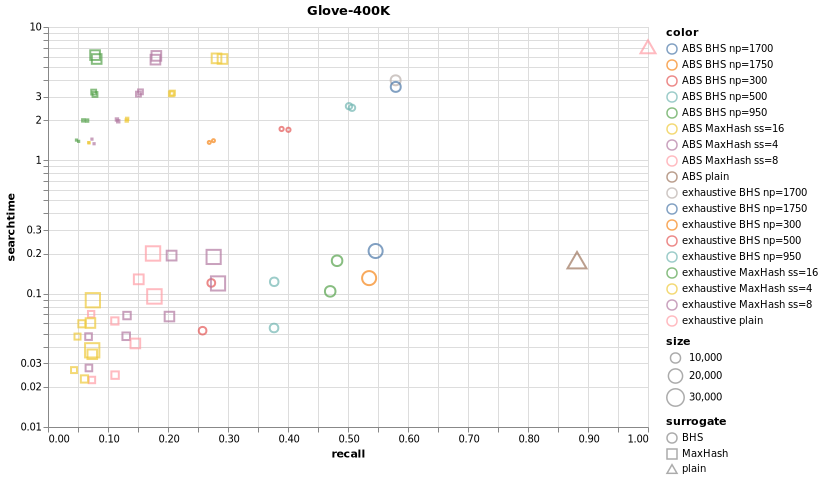

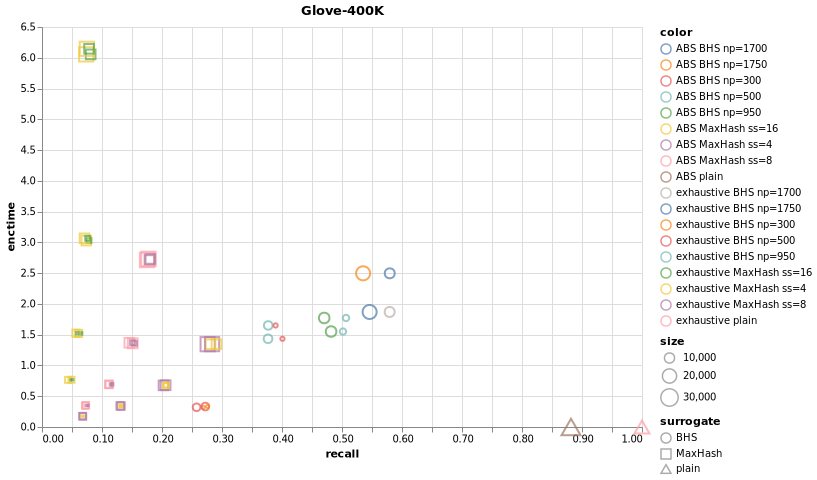

In [13]:
name = "Glove-400K"
D = read_dataframe(name)
plot_performance(D, name) |> display
plot_encode(D, name)

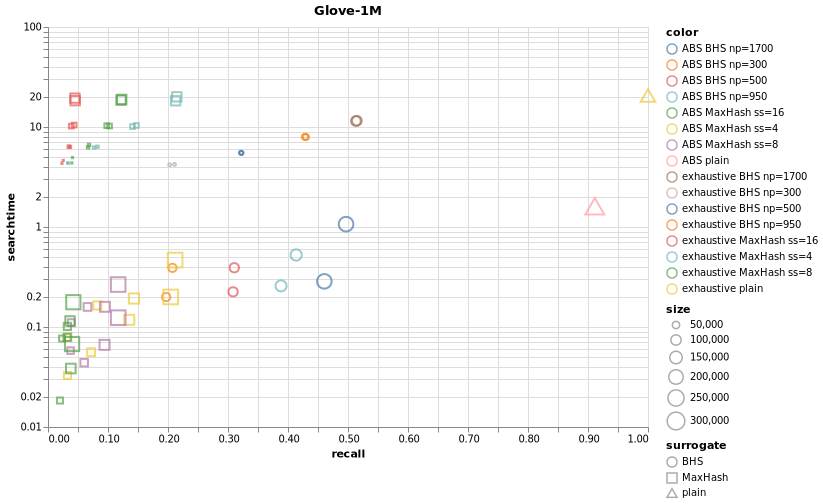

In [7]:
name = "Glove-1M"
D = read_dataframe(name)
plot_performance(D, name)

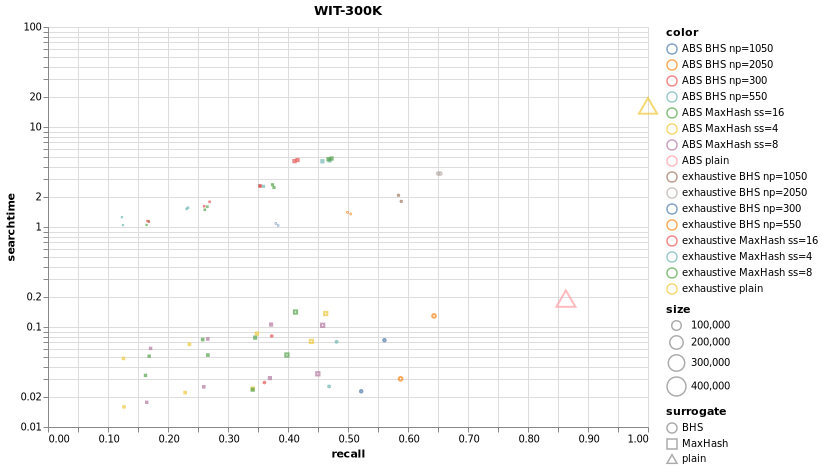

In [8]:
name = "WIT-300K"
D = read_dataframe(name)
plot_performance(D, name)

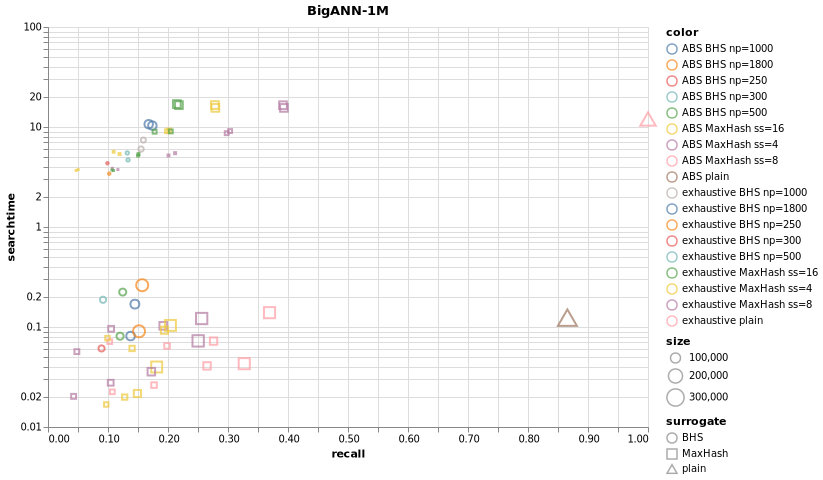

In [9]:
name = "BigANN-1M"
D = read_dataframe(name)
plot_performance(D, name)